**K-Nearest Neighbors Implementation for the Genre Classifier**

Imports for Code:

In [ ]:
# Machine Learning General Libraries
import pandas as pd
import numpy as np

# SKLearn
from sklearn import preprocessing

# Change this later
from sklearn.model_selection import train_test_split # Splitting
from sklearn.model_selection import cross_val_score # CV Score
from sklearn.model_selection import GridSearchCV # Grid Searching
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer # Preprocessing Tools
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score

# Python Libraries
import math

# Visualization
import matplotlib.pyplot as plt

# Numpy values are set to 3 digits of precision
np.set_printoptions(precision=3, suppress=True)

Loading the GTZAN Dataset:

In [ ]:
# We can read the original CSV from a GitHub repository
# url = 'https://raw.githubusercontent.com/rishilmysore/ml-project/main/features_3_sec.csv' # 3 sec ver.
# url = 'https://raw.githubusercontent.com/rishilmysore/ml-project/main/features_30_sec.csv' # 30 sec ver.

# Filled in mean values for the last missing segments (discussed in the report):
# Classical 49, Classical 51, Country 3, Country 4, Country 7, Disco 14,
# Hiphop 31, Hiphop 32, Rock 27, and Rock 38

# COMMENT THIS IF YOU ARE RUNNING THIS NOTEBOOK ON YOUR LOCAL MACHINE:
url = 'https://raw.githubusercontent.com/rishilmysore/ml-project/main/features_3_sec_means_for_missing_values.csv'
gtzan_dataset = pd.read_csv(url)

# UNCOMMENT THIS IF YOU ARE RUNNING THIS NOTEBOOK ON YOUR LOCAL MACHINE AND 
# CHANGE THE PATH TO THE CSV FILE ON YOUR MACHINE:
# gtzan_dataset = pd.read_csv(r"C:\Users\user\Downloads\features_3_sec_means_for_missing_values.csv")


# Head shows the first 5 values of the csv file (to make sure it's the right one)
gtzan_dataset.head()
print(f"{gtzan_dataset.shape[0]} rows, {gtzan_dataset.shape[1]} columns")

10000 rows, 60 columns


,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.0.wav,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.63090,1972.744388,117335.77160,...,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,blues.00000.1.wav,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.69087,2010.051501,65671.87567,...,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,blues.00000.2.wav,66149,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.43760,2084.565132,75124.92172,...,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues
3,blues.00000.3.wav,66149,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.28450,1960.039988,82913.63927,...,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
4,blues.00000.4.wav,66149,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.26765,1948.503884,60204.02027,...,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,blues


Pre-processing:

In [ ]:
# We can also extract the genre (label) from the set and use it
gtzan_features = gtzan_dataset.copy()

# With pop we can remove the names and labels from gtzan_features and store it into respective variables
gtzan_labels = gtzan_features.pop('label')
gtzan_filenames = gtzan_features.pop('filename')

# To make it easier to perform KNN, the string labels are converted into a numerical representation (i.e. blues = 0, rock = 9)
encoder = preprocessing.LabelEncoder()
gtzan_numerical_labels = encoder.fit_transform(gtzan_labels)
# print(gtzan_numerical_labels)

# We also need to normalize the data, SKLearn provides good preprocessing tools.
# Quantile Transformer and Robust Scaler both help to scale the features into
# a distribution which is good for outliers. 
qt = preprocessing.QuantileTransformer(output_distribution='normal')
gtzan_features = pd.DataFrame(qt.fit_transform(gtzan_features), columns = gtzan_features.columns)

robust_scaler = preprocessing.RobustScaler()
gtzan_features = pd.DataFrame(robust_scaler.fit_transform(gtzan_features), columns = gtzan_features.columns)

# Min Max scaler scales each feature to a certain range (0 to 1 for example)
# with the minimum and maximum values of a feature.
mm_scaler = preprocessing.MinMaxScaler()
gtzan_features = pd.DataFrame(mm_scaler.fit_transform(gtzan_features), columns = gtzan_features.columns)

# Conversion to a numpy array which has all the features except the ones removed earlier
gtzan_features = np.array(gtzan_features)
# print(gtzan_features)

Splitting:

In [ ]:
"""
Since we have 10 segments of the same song, there is a possibility that when we
split between training and testing then this will lead towards extremely high 
accuracies due to the fact that some parts of a song are repetitive 
and therefore are similar in values.

To help mitigate this issue we could random select from each songset (of 10 features)
when we train. Stratified Sampling allows you to select from each genre with equal proportion.
"""
# - Random_state is a fixed random number generator, remove to randomize each time this is ran
# - Train_test_split splits the data into training and test with the features (x) and
# training and test with the genres (y).
# - SKLearn also offers stratified cross-validation
features_train, features_test, genres_train, genres_test = train_test_split(gtzan_features, 
  gtzan_numerical_labels, test_size = 0.2, stratify = gtzan_numerical_labels, random_state = 16)

# 25% of 80% is 20% (i.e. 60-20-20 split)
# Manual Validation
#features_train, features_validation, genres_train, genres_validation = train_test_split(features_train, 
#  genres_train, test_size=0.25, stratify = genres_train)
print(features_train.shape, features_test.shape, genres_train.shape, genres_test.shape) # features_validation.shape, genres_validation.shape)

(8000, 58) (2000, 58) (8000,) (2000,)


Initial K Value:

In [ ]:
# Smaller values are more sensitive to noise (leads to overfitting) 
# but large values are computationally expensive (leads to underfitting)

# Could choose the square root of the number of features or data points we are looking at:
# K = math.sqrt(gtzan_dataset.shape[0])

# Or a fixed number:
K = 15 # 5 has the highest test accuracy, but 15 is the best in terms of cross validation

# Either way it has to be a whole number which should be odd since KNN is a 
# majority based algorithm and even numbers would result in ties:
K = round(K)
if K % 2 == 0:
  K -= 1

print("Our algorithm will check against the", K, "nearest neighbors for a data point.")

Our algorithm will check against the 15 nearest neighbors for a data point.


Parameter Searching with GridSearchCV:

In [ ]:
# With model.get_params(), these are the hyperparameters we can look at:
# {'algorithm': 'auto', 'metric': 'minkowski', 'metric_params': None,
# 'n_neighbors': K, 'weights': 'distance'}
# Others such as leaf_size and n_jobs don't affect the accuracy but rather the speed of the model
model = KNeighborsClassifier(n_neighbors = K)
grid = {'n_neighbors': np.arange(5, 20), 'algorithm': ['ball_tree', 'kd_tree', 'brute'], 
        'metric': ['euclidean', 'manhattan'], 'weights': ['uniform', 'distance']}

"""
Takes roughly 20 minutes to execute the GridSearchCV, but from this, we found
that the best score came from using the ball tree algorithm, manhattan metric,
11 nearest neighbors, and weights based on distance.
"""
# model_gs = GridSearchCV(model, grid, cv = 10)
# model_gs.fit(gtzan_features, gtzan_numerical_labels)
# print(model_gs.best_params_)
# print(model_gs.best_score_)

# Creating the Model
model = KNeighborsClassifier(n_neighbors = K, algorithm = 'ball_tree', metric = 'manhattan',
          weights = 'distance')

In [ ]:
# Cross Validation Accuracy
cv_scores = cross_val_score(model, gtzan_features, gtzan_numerical_labels, cv = 10, scoring = "accuracy")
print(cv_scores.mean())

# Training the Model
model.fit(features_train, genres_train)
genres_prediction = model.predict(features_test)

0.6134


In [ ]:
# Model Accuracy
print("The accuracy of the model is", accuracy_score(genres_test, genres_prediction))

# With around a ~90% test accuracy and ~61% cv accuracy, there are some optimizations we can make
# and also means that the model doesn't generalize well (overfitting).

The accuracy of the model is 0.891


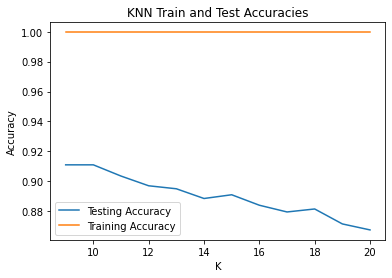

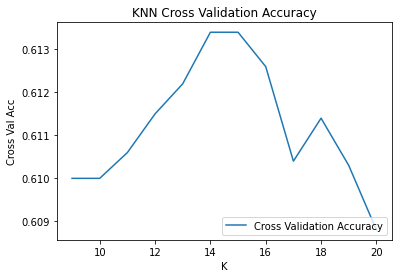

In [ ]:
# What is the best value of K (# of neighbors to look at to classify a point)? 
# Let's plot the accuracy rate against the K value
neighbors = np.arange(9, 19, 1) # Takes 2 minutes
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))
cross_val_scores = []

for i, K in enumerate(neighbors):
    model = KNeighborsClassifier(n_neighbors = K, algorithm = 'ball_tree', metric = 'manhattan',
            weights = 'distance')

    model.fit(features_train, genres_train)

    # Cross Validation Accuracy
    cv_scores = cross_val_score(model, gtzan_features, gtzan_numerical_labels, cv = 10, scoring = "accuracy")
    cross_val_scores.append(cv_scores.mean())

    # Getting the Training and Testing Accuracies
    train_accuracy[i] = model.score(features_train, genres_train)
    test_accuracy[i] = model.score(features_test, genres_test)

# Visualization of K Values vs. Accuracy
plt.plot(neighbors, test_accuracy, label = "Testing Accuracy")
plt.plot(neighbors, train_accuracy, label = "Training Accuracy")
plt.legend()
plt.xlabel("K")
plt.ylabel("Accuracy")
plt.title("KNN Train and Test Accuracies")
plt.show()

plt.plot(neighbors, cross_val_scores, label = "Cross Validation Accuracy")
plt.legend(loc="lower right")
plt.xlabel("K")
plt.ylabel("Cross Val Acc")
plt.title("KNN Cross Validation Accuracy")
plt.show()

# Good models would have a low inertia and low K value

# Why do we have a 100% training accuracy for our KNN model?